In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/data.csv", sep=';')
df.columns = [c.replace('\t', ' ').strip() for c in df.columns]
df = df.rename(columns={
    'Marital status': 'Marial Status',
    'Daytime/evening attendance': 'Daytime/Evening',
    'Previous qualification': 'Pre Qual',
    'Previous qualification (grade)': 'Pre Qual (grade)',
    'Nacionality': 'Nationality',
    'Mother\'s qualification': 'Mom\'s Qual',
    'Father\'s qualification': 'Dad\'s Qual',
    'Mother\'s occupation': 'Mom\'s Occupation',
    'Father\'s occupation': 'Dad\'s Occupation',
    'Educational special needs': 'Special Needs',
    'Scholarship holder': 'Scholarship',
    'Age at enrollment': 'Enroll Age',
    'Curricular units 1st sem (credited)': '1st - credited',
    'Curricular units 1st sem (enrolled)': '1st - enrolled',
    'Curricular units 1st sem (evaluations)': '1st - evaluations',
    'Curricular units 1st sem (grade)': '1st - grade',
    'Curricular units 1st sem (without evaluations)': '1st - no evaluations',
    'Curricular units 1st sem (approved)': '1st - approved',
    'Curricular units 2nd sem (credited)': '2nd - credited',
    'Curricular units 2nd sem (enrolled)': '2nd - enrolled',
    'Curricular units 2nd sem (evaluations)': '2nd - evaluations',
    'Curricular units 2nd sem (grade)': '2nd - grade',
    'Curricular units 2nd sem (without evaluations)': '2nd - no evaluations',
    'Curricular units 2nd sem (approved)': '2nd - approved',
})

df.head()

,Marial Status,Application mode,Application order,Course,Daytime/Evening,Pre Qual,Pre Qual (grade),Nationality,Mom's Qual,Dad's Qual,...,2nd - credited,2nd - enrolled,2nd - evaluations,2nd - approved,2nd - grade,2nd - no evaluations,Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# Anomaly Cleaning


In [3]:
# Drop invalid ages (enroll age <17 or >70, or application order <0)
df = df[(df['Enroll Age'] >= 17) & (df['Enroll Age'] <= 70)]
df = df[df['Application order'] >= 0]

# Drop invalid grades (admission or previous <95 or >190)
df = df[(df['Admission grade'] >= 95) & (df['Admission grade'] <= 190)]
df = df[(df['Pre Qual (grade)'] >= 95) & (df['Pre Qual (grade)'] <= 190)]

# Drop invalid semester metrics (e.g., approved > enrolled, evaluations <0)
for sem in ['1st', '2nd']:
    df = df[df[f'{sem} - approved'] <= df[f'{sem} - enrolled']]
    df = df[df[f'{sem} - evaluations'] >= 0]
    df = df[df[f'{sem} - grade'] >= 0]

# Drop rows with invalid binary/ordinal values (e.g., gender not 0/1)
df = df[df['Gender'].isin([0, 1])]
df = df[df['Scholarship'].isin([0, 1])]
df = df[df['Tuition fees up to date'].isin([0, 1])]

# Group Categorical Values


In [4]:
def marial(x):
    if x == 1:
        return 1  # Not married
    else:
        return 0

def app_mode(x):
    standard = {1, 5, 16, 17, 18}
    ordinance = {2, 10, 26, 27}
    mature = {7, 39, 44, 53}
    transfer = {42, 43, 51, 57}
    international = {15}

    if x in standard:
        return 0
    elif x in ordinance:
        return 1
    elif x in mature:
        return 2
    elif x in transfer:
        return 3
    elif x in international:
        return 4
    else:
        return 5
    
def course(x):
    eng_tech = {33, 9119}
    design_media = {171, 9070, 9670, 9773}
    agri_animal = {9003, 9130, 9085}
    business_mgmt = {9147, 9991, 9254}
    health = {9500, 9556}
    social_edu = {9238, 8014, 9853}

    if x in eng_tech:
        return 0
    elif x in design_media:
        return 1
    elif x in agri_animal:
        return 2
    elif x in business_mgmt:
        return 3
    elif x in health:
        return 4
    elif x in social_edu:
        return 5
    else:
        return 6  # unknown or future course

def pre_qual(x):
    basic = {19, 38}
    incomplete_secondary = {9, 10, 12, 14, 15}
    completed_secondary = {1}
    vocational = {39, 42}
    higher_undergrad = {2, 3, 6, 40}
    postgraduate = {4, 5, 43}
    
    if x in basic or x in incomplete_secondary or x in completed_secondary:
        return 0  # Lower Education
    elif x in vocational or x in higher_undergrad or x in postgraduate:
        return 1  # Higher Education
    else:
        return 2  # Unknown / other

def nationality(x):
    lusophone = {1, 21, 22, 24, 25, 26, 41}
    if x in lusophone:
        return 0  # Portuguese / Lusophone
    else:
        return 1  # Other Foreign
    
def qual(x):
    basic = {11, 14, 18, 19, 22, 26, 27, 29, 30, 35, 36, 37, 38}
    secondary = {1, 9, 10, 12}
    higher = {2, 3, 6, 39, 40, 42}
    postgrad = {4, 5, 41, 43, 44}
    
    if x in basic:
        return 0
    elif x in secondary:
        return 1
    elif x in higher:
        return 2
    elif x in postgrad:
        return 3
    else:
        return 4

def moms_job(x):
    student = {0, 90, 99}
    professional = {1, 2, 3, 122, 123, 125, 131, 132, 134}
    admin_service = {4, 5, 141, 143, 144, 151, 152, 153}
    manual = {6, 7, 8, 9, 171, 173, 175, 191, 192, 193, 194}
    military = {10}

    if x in student:
        return 0
    elif x in professional:
        return 1
    elif x in admin_service:
        return 2
    elif x in manual:
        return 3
    elif x in military:
        return 4
    else:
        return 0
    
def dads_job(x):
    student = {0, 90, 99}
    professional = {1, 2, 3, 112, 114, 121, 122, 123, 124, 131, 132, 134, 135}
    admin_service = {4, 5, 141, 143, 144, 151, 152, 153, 154, 195}
    manual = {6, 7, 8, 9, 161, 163, 171, 172, 174, 175, 181, 182, 183, 192, 193, 194}
    military = {10, 101, 102, 103}
    
    if x in student:
        return 0
    elif x in professional:
        return 1
    elif x in admin_service:
        return 2
    elif x in manual:
        return 3
    elif x in military:
        return 4
    else:
        return 0

In [5]:
df_prep = df.copy()
useless_cols = ['Debtor', 'Special Needs', 'Unemployment rate', 'Inflation rate', 'GDP']
df_prep = df_prep.drop(columns=useless_cols)

col_func_map = {
    'Marial Status': lambda x: marial(x),
    'Application mode': lambda x: app_mode(x),
    'Course': lambda x: course(x),
    'Pre Qual': lambda x: pre_qual(x),
    'Nationality': lambda x: nationality(x),
    "Mom's Qual": lambda x: qual(x),
    "Dad's Qual": lambda x: qual(x),
    "Mom's Occupation": lambda x: moms_job(x),
    "Dad's Occupation": lambda x: dads_job(x)
}

for col, func in col_func_map.items():
    df_prep[col] = df_prep[col].apply(func)

df_prep.head()

,Marial Status,Application mode,Application order,Course,Daytime/Evening,Pre Qual,Pre Qual (grade),Nationality,Mom's Qual,Dad's Qual,...,1st - approved,1st - grade,1st - no evaluations,2nd - credited,2nd - enrolled,2nd - evaluations,2nd - approved,2nd - grade,2nd - no evaluations,Target
0,1,0,5,1,1,0,122.0,0,0,1,...,0,0.000000,0,0,0,0,0,0.000000,0,Dropout
1,1,4,1,3,1,0,160.0,0,1,2,...,6,14.000000,0,0,6,6,6,13.666667,0,Graduate
2,1,0,5,1,1,0,122.0,0,0,0,...,0,0.000000,0,0,6,0,0,0.000000,0,Dropout
3,1,0,2,1,1,0,122.0,0,0,0,...,6,13.428571,0,0,6,10,5,12.400000,0,Graduate
4,0,2,1,5,0,0,100.0,0,0,0,...,5,12.333333,0,0,6,6,6,13.000000,0,Graduate


In [6]:
df_prep.describe()

,Marial Status,Application mode,Application order,Course,Daytime/Evening,Pre Qual,Pre Qual (grade),Nationality,Mom's Qual,Dad's Qual,...,1st - evaluations,1st - approved,1st - grade,1st - no evaluations,2nd - credited,2nd - enrolled,2nd - evaluations,2nd - approved,2nd - grade,2nd - no evaluations
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,0.885850,0.864828,1.727848,2.787975,0.890823,0.107369,132.613314,0.008137,0.672920,0.533228,...,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316
std,0.318029,1.156445,1.313793,1.517635,0.311897,0.309617,13.188332,0.089850,0.964169,0.906319,...,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,125.000000,0.000000,0.000000,0.000000,...,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000
50%,1.000000,0.000000,1.000000,3.000000,1.000000,0.000000,133.100000,0.000000,0.000000,0.000000,...,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000
75%,1.000000,2.000000,2.000000,4.000000,1.000000,0.000000,140.000000,0.000000,1.000000,1.000000,...,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000
max,1.000000,4.000000,9.000000,5.000000,1.000000,1.000000,190.000000,1.000000,4.000000,4.000000,...,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000


In [7]:
df_prep.to_csv("../data/preprocessed.csv", index=False)

# Processed Dataset Visualization


In [8]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    print(f"Saving figure {fig_id} at {path}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure target_by_categorical_preprocessed at /Users/macbook/Downloads/HCMUT/Assignments/Machine Learning/images/target_by_categorical_preprocessed.png


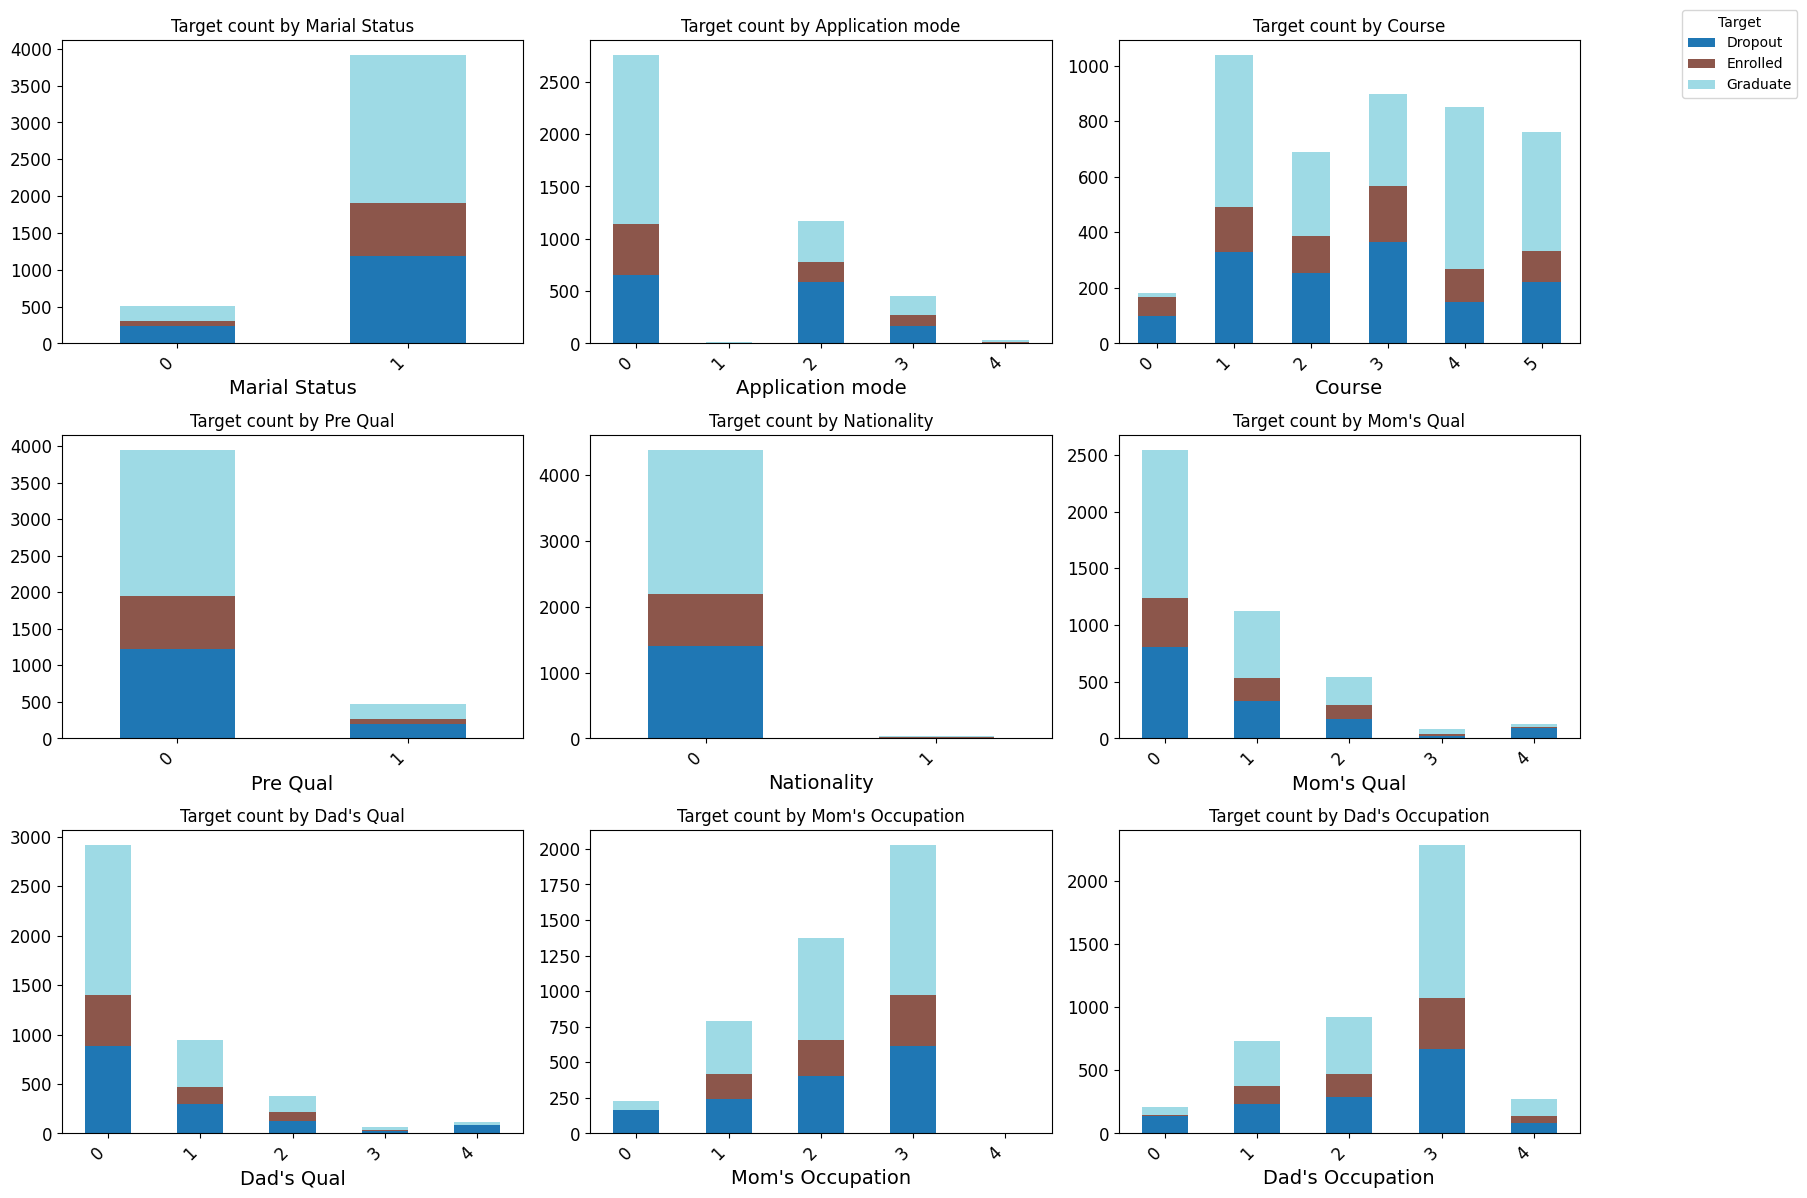

In [9]:
cat_candidates = [
    'Marial Status',
    'Application mode',
    'Course',
    'Pre Qual',
    'Nationality',
    "Mom's Qual",
    "Dad's Qual",
    "Mom's Occupation",
    "Dad's Occupation"
]
all_cats = [c for c in cat_candidates if c in df.columns]
n = len(all_cats)
cols = 3
rows = int(np.ceil(n / cols)) if n > 0 else 1
fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
axes = np.array(axes).flatten()

legend_handles_labels = None
for i, col in enumerate(all_cats):
    ct = pd.crosstab(df_prep[col], df_prep['Target'])
    ct = ct.loc[ct.index.sort_values()]
    plot = ct.plot(kind='bar', stacked=True, colormap='tab20', ax=axes[i])
    axes[i].set_title(f'Target count by {col}')
    axes[i].set_ylabel(None)
    axes[i].set_xlabel(col)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    if legend_handles_labels is None:
        legend_handles_labels = axes[i].get_legend_handles_labels()
    axes[i].get_legend().remove()  # Remove legends from individual axes

if legend_handles_labels is not None:
    handles, labels = legend_handles_labels
    fig.legend(handles, labels, title='Target', bbox_to_anchor=(1.05, 1), loc='upper left')

# Hide unused axes if any
for j in range(len(all_cats), len(axes)):
    axes[j].axis('off')
plt.tight_layout()
save_fig('target_by_categorical_preprocessed')